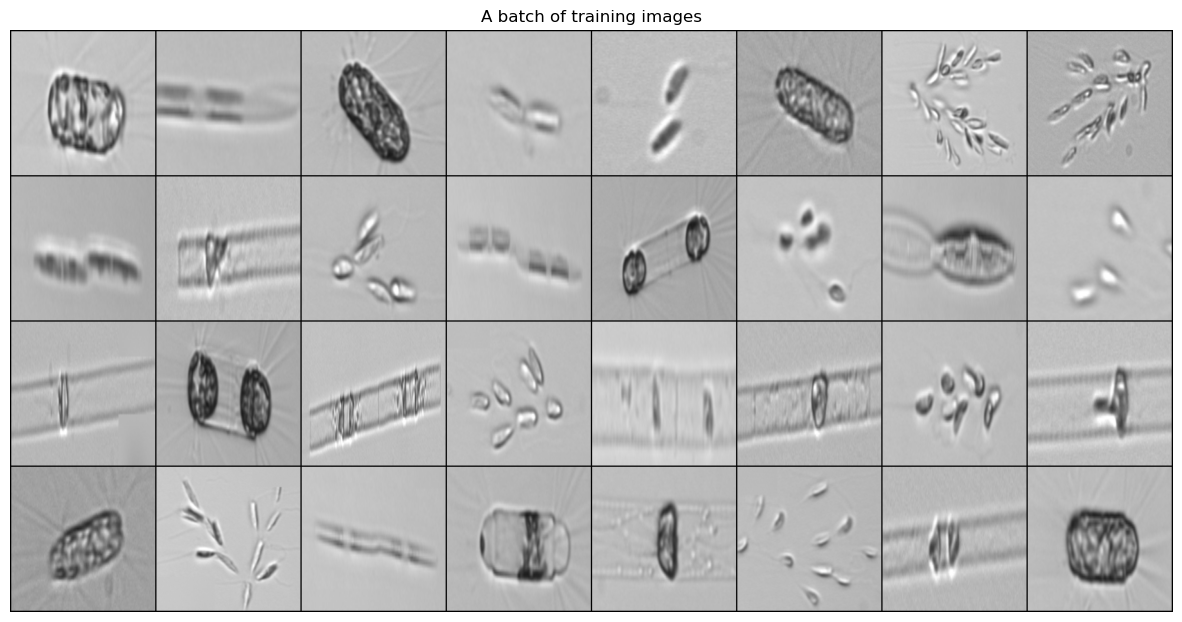

Labels:
['Corethron', 'Pseudonitzschia', 'Corethron', 'Dinobryon', 'Dinobryon', 'Corethron', 'Dinobryon', 'Dinobryon', 'Pseudonitzschia', 'Dactyliosolen', 'Dinobryon', 'Pseudonitzschia', 'Corethron', 'Dinobryon', 'Pseudonitzschia', 'Dinobryon', 'Dactyliosolen', 'Corethron', 'Dactyliosolen', 'Dinobryon', 'Dactyliosolen', 'Dactyliosolen', 'Dinobryon', 'Dactyliosolen', 'Corethron', 'Dinobryon', 'Pseudonitzschia', 'Corethron', 'Dactyliosolen', 'Dinobryon', 'Dactyliosolen', 'Corethron']


In [7]:
import os
import numpy as np
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

image_size = 224
batch_size = 32
data_dir = "data"

all_data = datasets.ImageFolder(data_dir)
class_names = all_data.classes

indices = list(range(len(all_data)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[all_data.imgs[i][1] for i in indices], random_state=42)

from torch.utils.data import Subset

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

all_data.transform = train_transforms
train_dataset = Subset(all_data, train_idx)
all_data.transform = val_transforms
val_dataset = Subset(all_data, val_idx)

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Batch visualize
images, labels = next(iter(train_loader))

def show_images(images, labels, class_names):
    # If normalized with mean=0.5, std=0.5 → undo it
    unnorm_images = images * 0.5 + 0.5  # unnormalize to [0,1]
    img_grid = utils.make_grid(unnorm_images, nrow=8)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(img_grid.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
    plt.title("A batch of training images")
    plt.axis('off')
    plt.show()

    # Optional: Print labels
    print("Labels:")
    print([class_names[i] for i in labels])

show_images(images, labels, class_names)

# Modelings

# SUPERVISED

In [8]:
import torch
import torch.nn as nn
import time
from torchvision import models
from torchvision.models import ResNet18_Weights, VGG16_Weights, MobileNet_V2_Weights

def get_model(name, num_classes):
    if name == "resnet18":
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "vgg16":
        model = models.vgg16(weights=VGG16_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "mobilenet_v2":
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Unsupported model")
    return model

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    start_time = time.time()
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc, epoch_time

def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show()

def plot_metrics(metrics_dict):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Define custom color map
    color_map = {
        "resnet18": "blue",
        "vgg16": "gold",
        "mobilenet_v2": "green"
    }

    # Loss plot
    for model_name, metrics in metrics_dict.items():
        color = color_map.get(model_name, "black")  # default to black if not found
        axs[0, 0].plot(metrics['train_loss'], label=f"{model_name} Train", color=color)
        axs[0, 0].plot(metrics['val_loss'], label=f"{model_name} Val", linestyle='--', color=color)
    axs[0, 0].set_title('Loss over Epochs')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Accuracy plot
    for model_name, metrics in metrics_dict.items():
        color = color_map.get(model_name, "black")  # default to black if not found
        axs[0, 1].plot(metrics['train_acc'], label=f"{model_name} Train", color=color)
        axs[0, 1].plot(metrics['val_acc'], label=f"{model_name} Val", linestyle='--', color=color)
    axs[0, 1].set_title('Accuracy over Epochs')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    # Epoch time bar chart
    model_names = list(metrics_dict.keys())
    avg_times = [np.mean(metrics_dict[model]['epoch_time']) for model in model_names]
    axs[1, 0].bar(model_names, avg_times, color=['blue', 'orange', 'green'])
    axs[1, 0].set_title('Average Epoch Training Time')
    axs[1, 0].set_xlabel('Model')
    axs[1, 0].set_ylabel('Time (seconds)')
    for i, v in enumerate(avg_times):
        axs[1, 0].text(i, v + 0.1, f"{v:.2f}s", ha='center')
    
    # Final validation accuracy bar chart
    final_val_accs = [metrics_dict[model]['val_acc'][-1] for model in model_names]
    axs[1, 1].bar(model_names, final_val_accs, color=['blue', 'orange', 'green'])
    axs[1, 1].set_title('Final Validation Accuracy')
    axs[1, 1].set_xlabel('Model')
    axs[1, 1].set_ylabel('Accuracy')
    for i, v in enumerate(final_val_accs):
        axs[1, 1].text(i, v + 0.01, f"{v:.4f}", ha='center')
    
    plt.tight_layout()
    plt.show()

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

Training resnet18...
resnet18 | Epoch 1/10 | Train Loss: 0.1506 | Train Acc: 0.9499 | Val Loss: 0.0365 | Val Acc: 0.9953 | Time: 8.07s
resnet18 | Epoch 2/10 | Train Loss: 0.0183 | Train Acc: 0.9953 | Val Loss: 0.0144 | Val Acc: 0.9953 | Time: 7.18s
resnet18 | Epoch 3/10 | Train Loss: 0.0187 | Train Acc: 0.9965 | Val Loss: 0.0184 | Val Acc: 0.9953 | Time: 7.13s
resnet18 | Epoch 4/10 | Train Loss: 0.0044 | Train Acc: 0.9988 | Val Loss: 0.0098 | Val Acc: 0.9977 | Time: 7.34s
resnet18 | Epoch 5/10 | Train Loss: 0.0036 | Train Acc: 0.9994 | Val Loss: 0.0090 | Val Acc: 0.9977 | Time: 7.23s
resnet18 | Epoch 6/10 | Train Loss: 0.0013 | Train Acc: 1.0000 | Val Loss: 0.0083 | Val Acc: 0.9977 | Time: 7.10s
resnet18 | Epoch 7/10 | Train Loss: 0.0055 | Train Acc: 0.9988 | Val Loss: 0.0113 | Val Acc: 0.9977 | Time: 7.17s
resnet18 | Epoch 8/10 | Train Loss: 0.0014 | Train Acc: 1.0000 | Val Loss: 0.0077 | Val Acc: 0.9977 | Time: 7.15s
resnet18 | Epoch 9/10 | Train Loss: 0.0007 | Train Acc: 1.0000 | Va

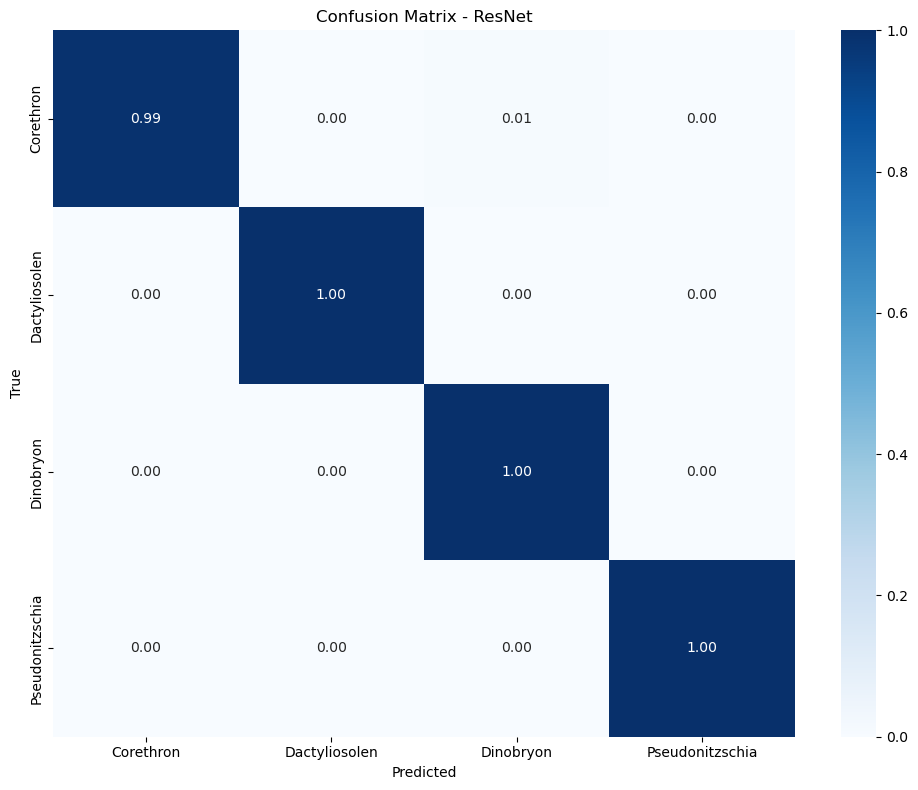

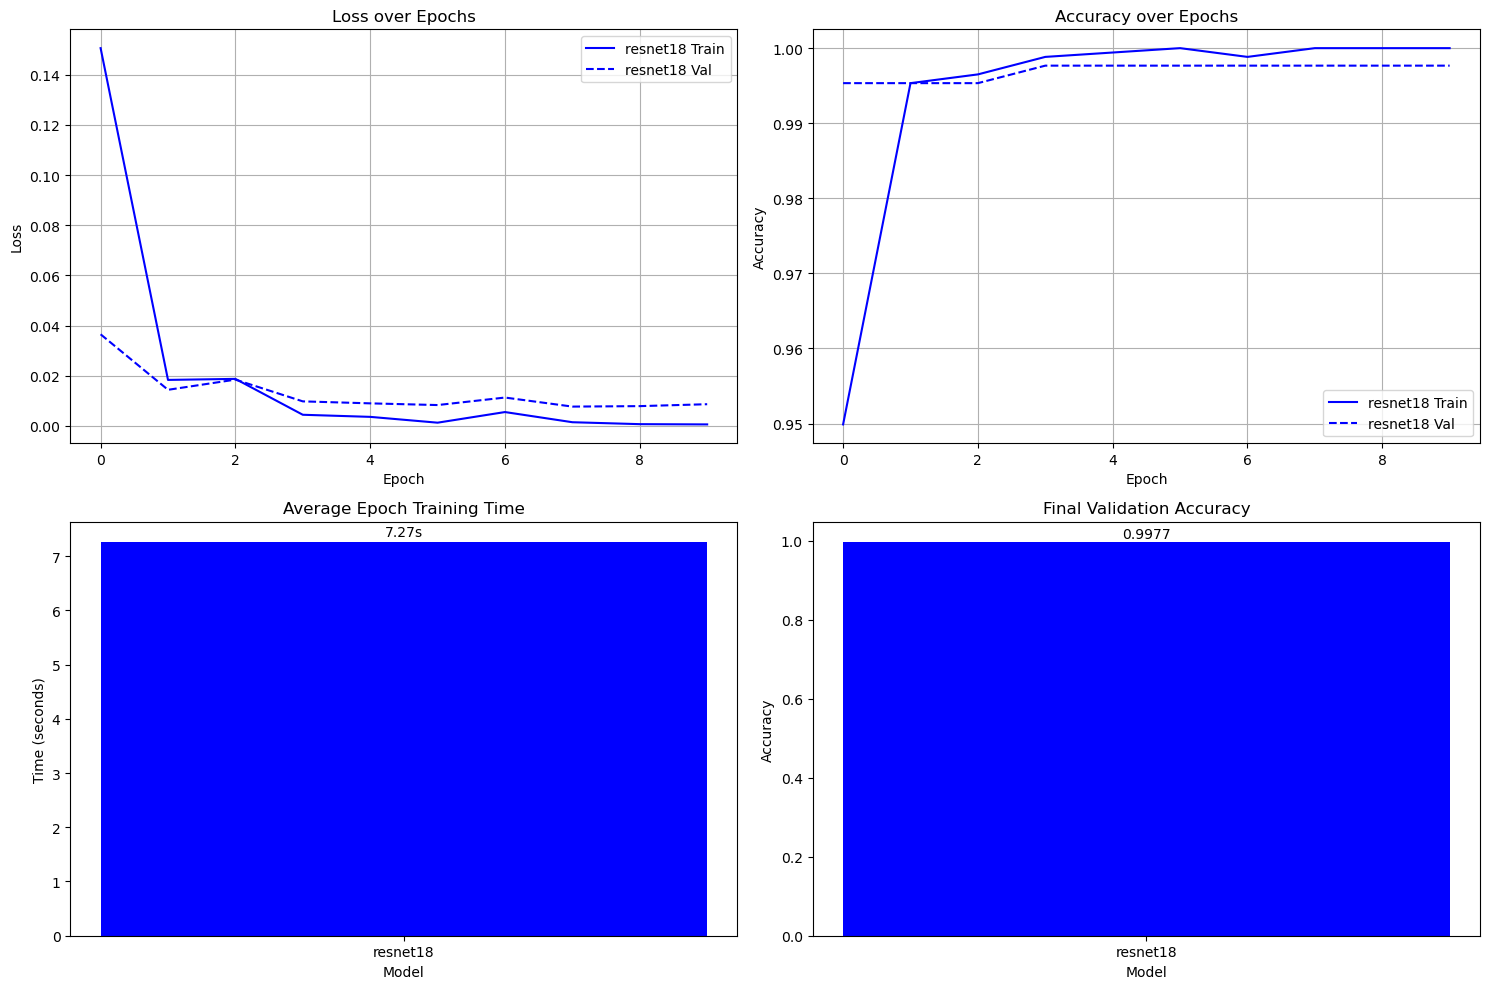

Training vgg16...
vgg16 | Epoch 1/10 | Train Loss: 0.1881 | Train Acc: 0.9400 | Val Loss: 0.0355 | Val Acc: 0.9883 | Time: 32.31s
vgg16 | Epoch 2/10 | Train Loss: 0.0241 | Train Acc: 0.9942 | Val Loss: 0.0214 | Val Acc: 0.9953 | Time: 32.21s
vgg16 | Epoch 3/10 | Train Loss: 0.0311 | Train Acc: 0.9936 | Val Loss: 0.0642 | Val Acc: 0.9837 | Time: 32.16s
vgg16 | Epoch 4/10 | Train Loss: 0.0155 | Train Acc: 0.9953 | Val Loss: 0.1299 | Val Acc: 0.9720 | Time: 32.15s
vgg16 | Epoch 5/10 | Train Loss: 0.0341 | Train Acc: 0.9918 | Val Loss: 0.0617 | Val Acc: 0.9907 | Time: 32.24s
vgg16 | Epoch 6/10 | Train Loss: 0.0281 | Train Acc: 0.9930 | Val Loss: 0.1149 | Val Acc: 0.9744 | Time: 32.08s
vgg16 | Epoch 7/10 | Train Loss: 0.0127 | Train Acc: 0.9959 | Val Loss: 0.0269 | Val Acc: 0.9930 | Time: 32.15s
vgg16 | Epoch 8/10 | Train Loss: 0.0243 | Train Acc: 0.9942 | Val Loss: 0.0363 | Val Acc: 0.9860 | Time: 32.30s
vgg16 | Epoch 9/10 | Train Loss: 0.0385 | Train Acc: 0.9918 | Val Loss: 0.0331 | Val A

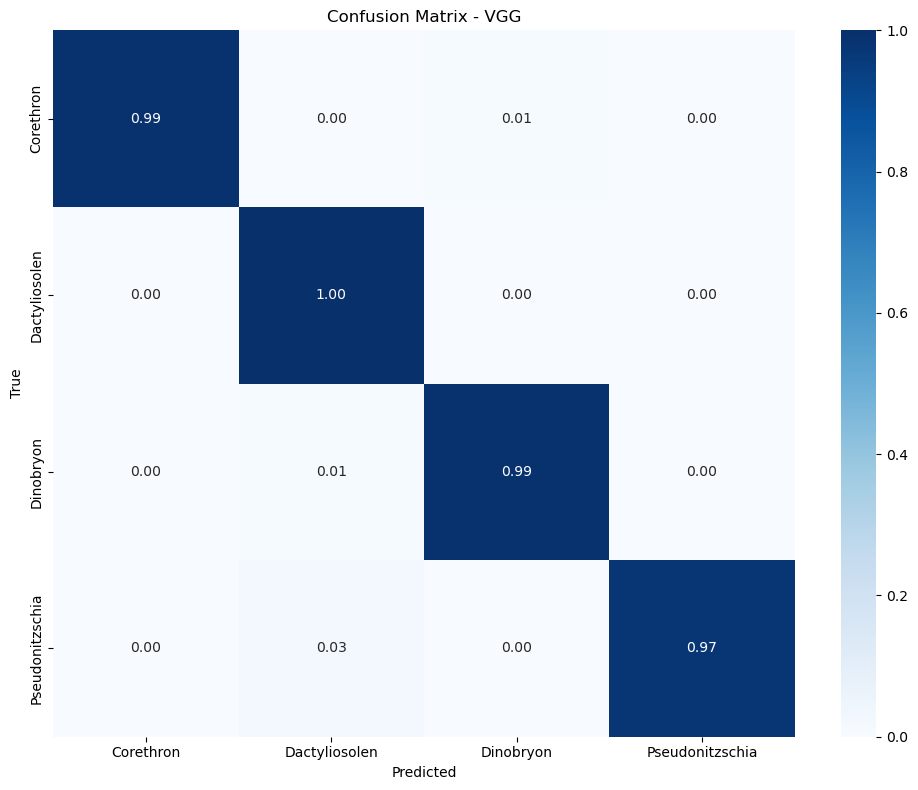

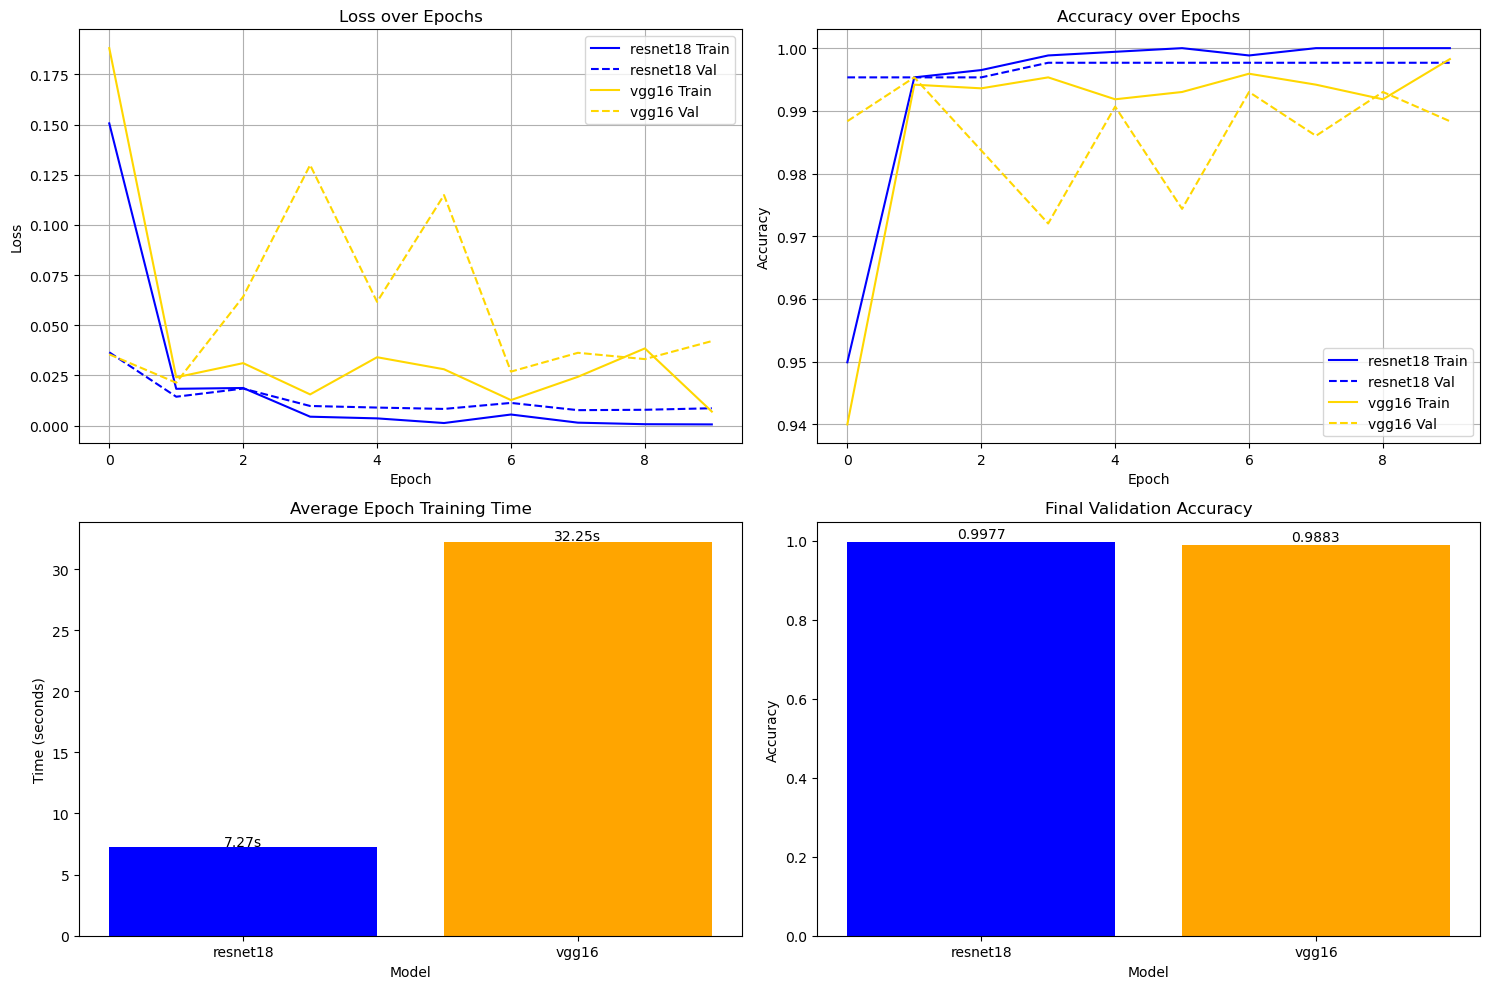

Training mobilenet_v2...
mobilenet_v2 | Epoch 1/10 | Train Loss: 0.6131 | Train Acc: 0.8869 | Val Loss: 0.3105 | Val Acc: 0.9814 | Time: 9.98s
mobilenet_v2 | Epoch 2/10 | Train Loss: 0.0871 | Train Acc: 0.9848 | Val Loss: 0.0376 | Val Acc: 0.9953 | Time: 7.98s
mobilenet_v2 | Epoch 3/10 | Train Loss: 0.0409 | Train Acc: 0.9936 | Val Loss: 0.0183 | Val Acc: 0.9977 | Time: 8.15s
mobilenet_v2 | Epoch 4/10 | Train Loss: 0.0229 | Train Acc: 0.9971 | Val Loss: 0.0121 | Val Acc: 0.9977 | Time: 7.99s
mobilenet_v2 | Epoch 5/10 | Train Loss: 0.0119 | Train Acc: 0.9977 | Val Loss: 0.0092 | Val Acc: 0.9977 | Time: 7.90s
mobilenet_v2 | Epoch 6/10 | Train Loss: 0.0098 | Train Acc: 0.9983 | Val Loss: 0.0074 | Val Acc: 0.9977 | Time: 7.87s
mobilenet_v2 | Epoch 7/10 | Train Loss: 0.0071 | Train Acc: 0.9994 | Val Loss: 0.0069 | Val Acc: 0.9977 | Time: 7.96s
mobilenet_v2 | Epoch 8/10 | Train Loss: 0.0044 | Train Acc: 1.0000 | Val Loss: 0.0081 | Val Acc: 0.9977 | Time: 8.10s
mobilenet_v2 | Epoch 9/10 | Tra

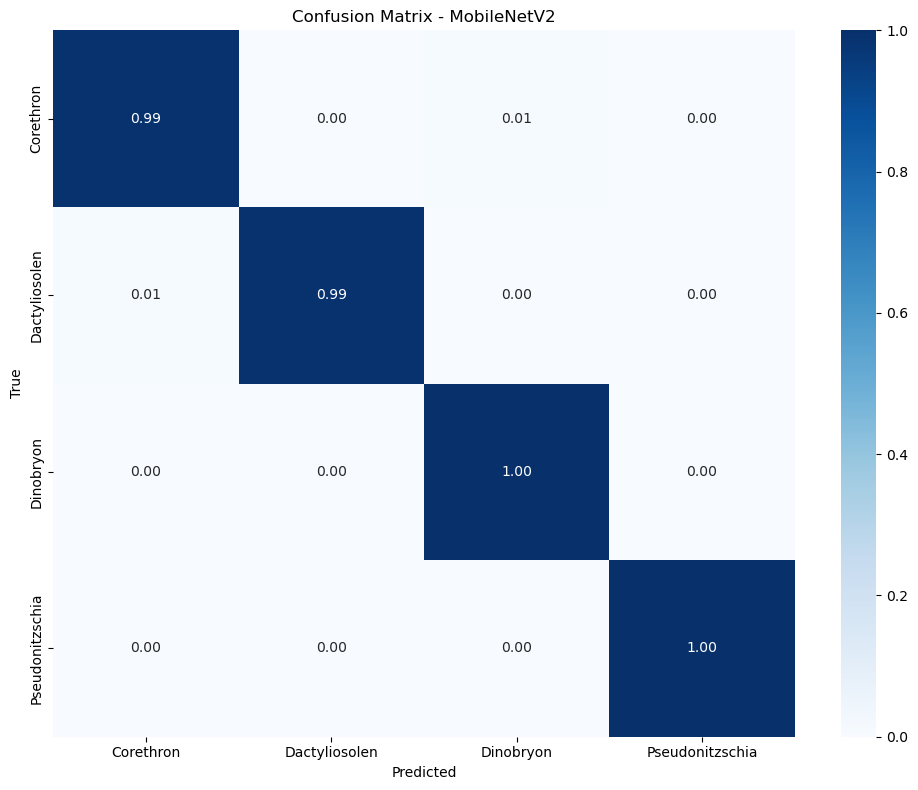

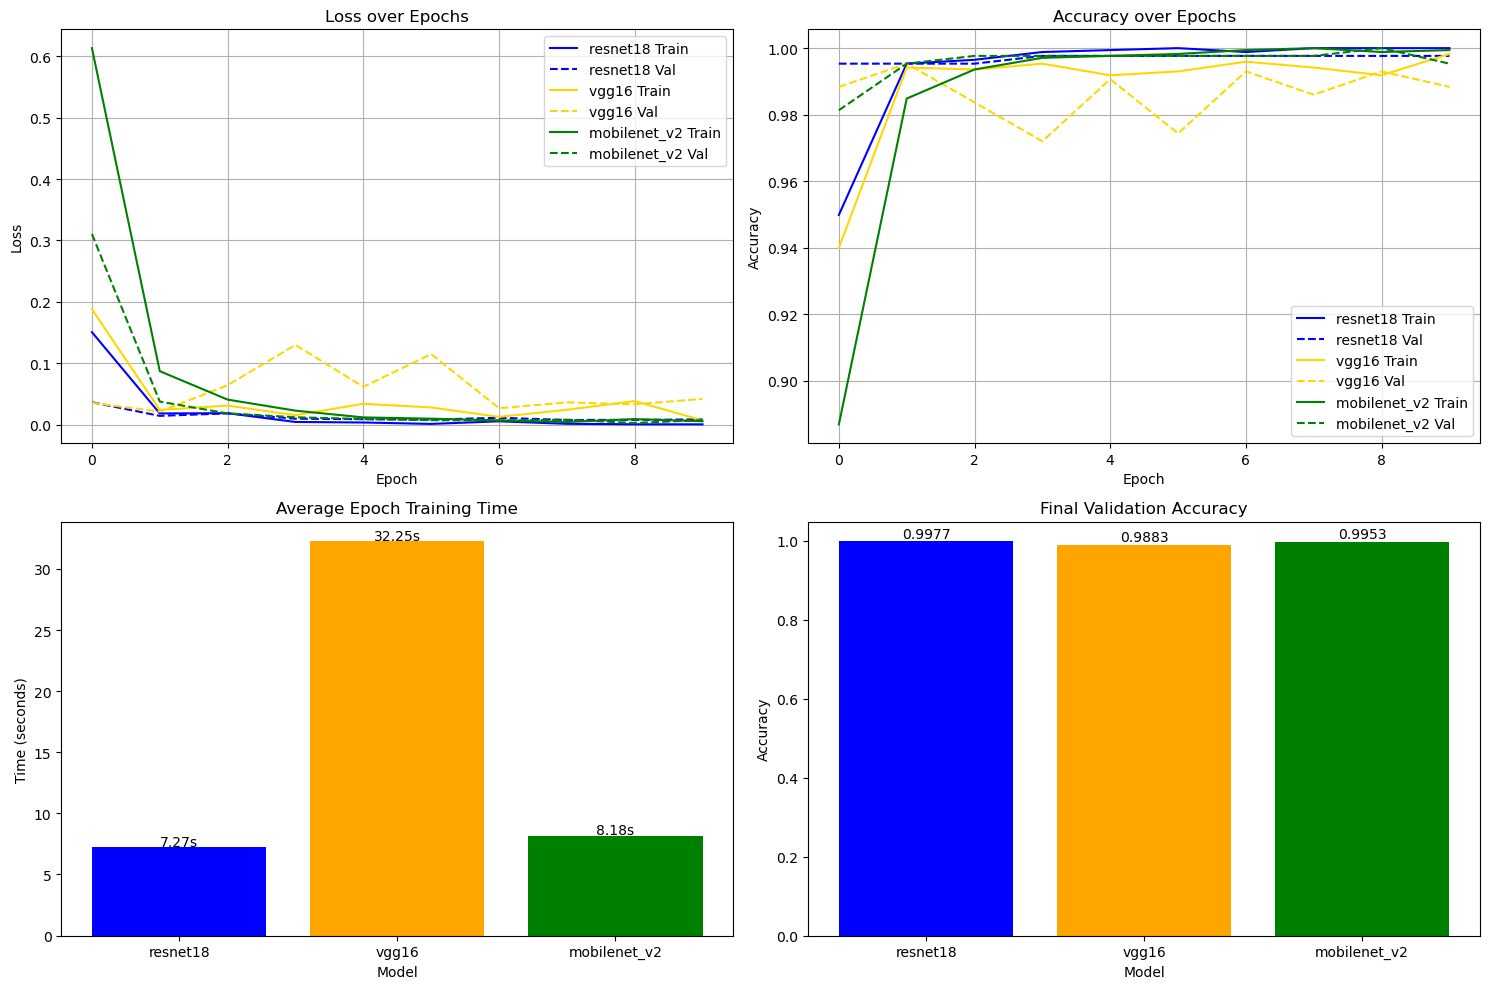

In [9]:
# running functions

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
num_classes = len(class_names)
models_to_try = ["resnet18", "vgg16", "mobilenet_v2"]
num_epochs = 10

all_metrics = {}

for model_name in models_to_try:
    print(f"Training {model_name}...")
    model = get_model(model_name, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    metrics = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'epoch_time': []
    }

    for epoch in range(num_epochs): 
        # train
        train_loss, train_acc, epoch_time = train_one_epoch(model, train_loader, criterion, optimizer, device)
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['epoch_time'].append(epoch_time) 
        # validate
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
        # print
        print(f"{model_name} | Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")
    
    # save metrics
    all_metrics[model_name] = metrics

    # generate confusion matrix
    plot_confusion_matrix(model, val_loader, class_names, device)

    # Plot all metrics
    plot_metrics(all_metrics)